### Open File

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv('./data/df_features.gz')

I delete the rows without a distance to city center (because in the origin hotel don't have latitude and longitude)

In [3]:
df = df.dropna(subset=['Dist_Center'])

### Filter by City

In [4]:
df = df[df.City == 'Vienna']

### Create Predicted Category for final models (2 categories)

In [5]:
diff_hotels = df[['Hotel_Address','Diff']].groupby('Hotel_Address').describe()
diff_hotels = diff_hotels.Diff.reset_index()

In [6]:
df = pd.merge(df, diff_hotels, on='Hotel_Address')

In [7]:
category = np.array(['Bad' if i < 7 else 'Good' for i in df.Reviewer_Score])
df.loc[:, 'Category'] = category
df.Category.value_counts() / len(df)

Good    0.869305
Bad     0.130695
Name: Category, dtype: float64

### Balance Nationalities and / or Categories

In [8]:
def balance_df(df, Balance_Nationality, Balance_Category, cut):
    df_balance_country = df.copy()
    if Balance_Nationality:
        df_balance_country = None
        for i in list(df.Nationality_Recode.value_counts().index):
            nationality = df[df.Nationality_Recode == i]
            n = cut
            if len(nationality) < n:
                n = len(nationality)
            nationality = nationality.sample(n, random_state=1)
            df_balance_country = pd.concat([df_balance_country, nationality])
    
    df_balance_class = df_balance_country.copy()
    if Balance_Category:
        df_balance_class = None
        minclass = np.min(df_balance_country.Category.value_counts())
        classes = list(df_balance_country.Category.value_counts().index)
        for i in classes:
            selected_class = df_balance_country[df_balance_country.Category == i].sample(minclass, random_state=1)
            df_balance_class = pd.concat([df_balance_class, selected_class])
    
    return(df_balance_class)

In [9]:
df_balanced_1 = balance_df(df, Balance_Nationality=False, Balance_Category=True, cut=10000)
df_balanced_2 = balance_df(df_balanced_1, Balance_Nationality=True, Balance_Category=True, 
                         cut=int(np.median(df_balanced_1.Nationality_Recode.value_counts())*2))
df_balanced_2.shape

(6672, 78)

In [10]:
df_balanced_2.Nationality_Recode.value_counts()

UK & Ireland           1185
Eastern Europe         1184
Western Europe         1183
Middle east            1014
North America           806
Asia & Pacific          591
Oceania                 390
South/Latin America     110
Sub-Saharian Africa      83
China                    75
Arab States              51
Name: Nationality_Recode, dtype: int64

### Prepare Data to run Models

In [11]:
if len(df_balanced_2) > 20000:
    df_model = df_balanced_2.sample(n=20000, random_state=1)
else:
    df_model = df_balanced_2.copy()

df_model.shape

(6672, 78)

In [12]:
x_categorical = ['Review_Month','City','Pet','Purpose','Whom','Room_Recode','Nationality_Recode','Length_Recode','Stars']
x_numerical = ['Average_Score', 'Total_Number_of_Reviews_Reviewer_Has_Given', 'Close_Landmarks', 'Dist_Center', 
               'Dist_Train', 'Dist_Airport','food_Neg_Hotel','staff_Neg_Hotel', 'location_Neg_Hotel', 'value_Neg_Hotel',
               'comfort_Neg_Hotel', 'room_Neg_Hotel', 'facilities_Neg_Hotel','cleanliness_Neg_Hotel', 
               'food_Pos_Hotel', 'staff_Pos_Hotel','location_Pos_Hotel', 'value_Pos_Hotel', 'comfort_Pos_Hotel',
               'room_Pos_Hotel', 'facilities_Pos_Hotel', 'cleanliness_Pos_Hotel','count', 'mean', 'std', 'min', '25%', 
               '50%', '75%', 'max']
x_col = x_categorical + x_numerical
y_col = 'Category'

In [13]:
X_numerical = df_model[x_numerical]
X_numerical_std = X_numerical.apply(lambda x: ((x-np.mean(x)) / np.std(x)))

In [14]:
df_model['Review_Month'] = df_model['Review_Month'].astype(str)
X_categorical = pd.get_dummies(df_model[x_categorical], prefix_sep='_', drop_first=True)
X_categorical = X_categorical.fillna('Not Available')

In [15]:
X = pd.concat([X_numerical_std, X_categorical], axis=1, sort=False)
y = df_model[y_col]

Split into Train and Test

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y, random_state=1)

In [17]:
X_test.shape, y_test.shape, X_train.shape, y_train.shape

((3336, 72), (3336,), (3336, 72), (3336,))

## MODELS

### Evaluate Model

In [18]:
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, precision_score, recall_score, make_scorer

In [19]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    clf = model
    clf.fit(X_train, y_train)
    print_result(clf, X_train, X_test, y_train, y_test)
    return(clf.predict(X_test))

In [20]:
def evaluate_random(model, params, iterations, X_train, X_test, y_train, y_test, verbose = 1):
    f1 = make_scorer(f1_score, pos_label = "Bad")
    clf = RandomizedSearchCV(estimator = model, param_distributions = params, n_iter = iterations, scoring = f1, 
                             n_jobs = -1, cv = 5, random_state = 27, verbose = verbose)
    clf.fit(X_train, y_train)
    print(clf.best_params_, clf.best_score_)
    print_result(clf, X_train, X_test, y_train, y_test)
    return(clf.predict(X_test))

In [21]:
def evaluate_grid(model, params, X_train, X_test, y_train, y_test, verbose = 1):
    f1 = make_scorer(f1_score, pos_label = "Bad")
    clf = GridSearchCV(estimator = model, param_grid = params, scoring = f1, n_jobs = -1, cv = 5, verbose = verbose)    
    clf.fit(X_train, y_train)
    print(clf.best_params_, clf.best_score_)
    print_result(clf, X_train, X_test, y_train, y_test)
    return(clf.predict(X_test))

In [22]:
def print_result(clf, X_train, X_test, y_train, y_test):
    print('Accuracy Test :', f'{accuracy_score(clf.predict(X_test), y_test):.4f}', 
          '| F1 Test :', f'{f1_score(clf.predict(X_test), y_test, pos_label="Bad"):.4f}')
    print('Accuracy Train:', f'{accuracy_score(clf.predict(X_train), y_train):.4f}', 
          '| F1 Train:', f'{f1_score(clf.predict(X_train), y_train, pos_label="Bad"):.4f}')

### KNN

In [23]:
pred_knn = evaluate_model(KNeighborsClassifier(n_neighbors=5), X_train, X_test, y_train, y_test)

Accuracy Test : 0.6112 | F1 Test : 0.6175
Accuracy Train: 0.7350 | F1 Train: 0.7386


### Gradient Boosted Trees

In [24]:
iterations = 100
params = {'learning_rate':  [0.001, 0.0025, 0.005 , 0.01, 0.025, 0.05, 0.1], 
          'n_estimators': range(100, 200),
          'max_depth': [2, 3, 4, 5],
          'min_samples_split': np.linspace(0.1, 1.0, 100, endpoint=True),
          'min_samples_leaf': np.linspace(0.01, 0.5, 100, endpoint=True), 
          'subsample': [1], 
          'max_features': ['sqrt']}

pred_gbt = evaluate_random(GradientBoostingClassifier(), params, iterations, X_train, X_test, y_train, y_test, verbose = 0)

{'subsample': 1, 'n_estimators': 149, 'min_samples_split': 0.8454545454545453, 'min_samples_leaf': 0.08919191919191918, 'max_features': 'sqrt', 'max_depth': 4, 'learning_rate': 0.0025} 0.6797964126018753
Accuracy Test : 0.6301 | F1 Test : 0.6758
Accuracy Train: 0.6379 | F1 Train: 0.6774


In [25]:
# pred_gbt = evaluate_model(GradientBoostingClassifier(n_estimators = 165, 
#                                                      min_samples_split = 0.6272727272727272, 
#                                                      min_samples_leaf = 0.11888888888888888, 
#                                                      max_depth = 2, learning_rate = 0.001),
#                           X_train, X_test, y_train, y_test)

### Random Forest

In [26]:
iterations = 100
params = {'bootstrap': [True, False],
          'max_depth': range(1, 10),
          'max_features': ['auto', 'sqrt'],
          'min_samples_leaf': range(1, 10),
          'min_samples_split': range(1, 10),
          'n_estimators': range(100, 200)}

pred_rf = evaluate_random(RandomForestClassifier(random_state = 1), params, iterations, 
                          X_train, X_test, y_train, y_test, verbose = 0)

{'n_estimators': 177, 'min_samples_split': 7, 'min_samples_leaf': 9, 'max_features': 'auto', 'max_depth': 1, 'bootstrap': True} 0.6759180440020062
Accuracy Test : 0.6304 | F1 Test : 0.6736
Accuracy Train: 0.6358 | F1 Train: 0.6735


In [27]:
# pred_rf = evaluate_model(RandomForestClassifier(n_estimators = 153, min_samples_split = 5,  min_samples_leaf = 7,
#                                                 max_features = 'auto', max_depth = 2, bootstrap = False, random_state=1), 
#                          X_train, X_test, y_train, y_test)

### XGBoosting

In [28]:
iterations = 250
params = {"learning_rate"    : [0.0001, 0.005, 0.001, 0.005, 0.01, 0.05, 0.10, 0.25, 0.50],
          "max_depth"        : [2, 3, 4, 5, 6, 7, 8, 9, 10],
          "min_child_weight" : [1, 3, 5, 10, 25, 50, 100, 250],
          "gamma"            : [0.01, 0.05, 0.1, 0.15, 0.25, 0.50, 0.75, 0.95],
          "colsample_bytree" : [0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2],
          "n_estimators"     : [2, 3, 5, 7, 10, 15, 25, 50, 100]}

pred_xgb = evaluate_random(xgb.XGBClassifier(), params, iterations, X_train, X_test, y_train, y_test, verbose = 0)

{'n_estimators': 5, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.001, 'gamma': 0.5, 'colsample_bytree': 0.8} 0.6835560736061398
Accuracy Test : 0.6250 | F1 Test : 0.6645
Accuracy Train: 0.6568 | F1 Train: 0.6906


In [29]:
# pred_xgb = evaluate_model(xgb.XGBClassifier(n_estimators = 7, min_child_weight = 5, max_depth = 3, learning_rate = 0.005,
#                                             gamma = 0.05, colsample_bytree = 1, random_state = 1), 
#                     X_train, X_test, y_train, y_test)

### Logistic Regresion

In [30]:
params = {"C": [0.0001, 0.00025, 0.0005, 0.001, 0.0025, 0.005, 0.01, 0.025, 0.05, 0.1],
          "tol": [0.00001, 0.000025, 0.00005, 0.0001, 0.00025, 0.0005, 0.001, 0.0025, 0.005, 0.01, 0.025, 0.05, 0.1]}

pred_log = evaluate_grid(LogisticRegression(solver = 'lbfgs', max_iter = 1000, random_state = 1), 
                         params, X_train, X_test, y_train, y_test, verbose = 0)

{'C': 0.0025, 'tol': 1e-05} 0.6741219941836561
Accuracy Test : 0.6364 | F1 Test : 0.6641
Accuracy Train: 0.6568 | F1 Train: 0.6781


In [31]:
# pred_log = evaluate_model(LogisticRegression(C = 0.1, tol = 0.00001, solver='lbfgs', max_iter=1000, random_state=1), 
#                           X_train, X_test, y_train, y_test)

### Decision Trees

In [32]:
iterations = 500
params = {"max_depth": range(1, 10),
          "max_features": range(1, 20),
          "min_samples_leaf": range(1, 20),
          "criterion": ["gini", "entropy"]}

pred_tree = evaluate_random(DecisionTreeClassifier(random_state = 1), params, iterations, 
                            X_train, X_test, y_train, y_test, verbose = 0)

{'min_samples_leaf': 1, 'max_features': 7, 'max_depth': 1, 'criterion': 'gini'} 0.6872296165456356
Accuracy Test : 0.6079 | F1 Test : 0.6838
Accuracy Train: 0.6184 | F1 Train: 0.6888


In [33]:
# pred_tree = evaluate_model(DecisionTreeClassifier(min_samples_leaf = 4, max_features = 19, max_depth = 3, 
#                                                   criterion = 'entropy', random_state = 1), 
#                      X_train, X_test, y_train, y_test)

### SVM

In [34]:
params = {"degree": [2, 3, 4],
          "kernel": ['poly'], 
          "C":      [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2.5, 5]}

pred_svm = evaluate_grid(SVC(random_state = 1), params, X_train, X_test, y_train, y_test, verbose = 0)

{'C': 0.05, 'degree': 2, 'kernel': 'poly'} 0.695716799488373
Accuracy Test : 0.6166 | F1 Test : 0.6913
Accuracy Train: 0.6301 | F1 Train: 0.6971


In [35]:
# pred_svm = evaluate_model(SVC(kernel = 'poly', degree = 2, C = 0.005, random_state = 1), X_train, X_test, y_train, y_test)

### Naive Bayes

In [36]:
params = {"alpha": [0.1, 0.25, 0.5, 1, 2.5, 5, 10], 
          "fit_prior": [True, False]}

pred_nb = evaluate_grid(BernoulliNB(), params, X_train, X_test, y_train, y_test, verbose = 0)

{'alpha': 1, 'fit_prior': True} 0.651677788204618
Accuracy Test : 0.6283 | F1 Test : 0.6550
Accuracy Train: 0.6403 | F1 Train: 0.6604


In [37]:
# pred_nb = evaluate_model(BernoulliNB(alpha=0.25, fit_prior=True), X_train, X_test, y_train, y_test)

## STACKING

Predictions using Random Forest adding the predicions of other models to the original dataset.
I had to split the test set in 2 to create the new train/test set, otherwise i fall into overfitting because my original training set is biased vs the test set

First I append the predictions of the model to the dataset

In [38]:
X_2 = X_test.copy()
y_2 = y_test.copy()

In [39]:
X_2['logistic'] = pred_log
X_2['gbt'] = pred_gbt
X_2['knn'] = pred_knn
X_2['svm'] = pred_svm
X_2['tree'] = pred_tree
X_2['xgb'] = pred_xgb
X_2['nb'] = pred_nb
X_2['rf'] = pred_rf

In [40]:
X_2.iloc[:,-8:].head(2)

,logistic,gbt,knn,svm,tree,xgb,nb,rf
23336,Bad,Bad,Good,Bad,Bad,Bad,Bad,Bad
18635,Bad,Bad,Bad,Bad,Bad,Bad,Bad,Bad


In [41]:
X_2.iloc[:,-8:] = X_2.iloc[:,-8:].apply(lambda x: [1 if i=='Good' else 0 for i in x])

In [42]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, random_state=100)

### Gradient Boosting Trees

In [43]:
iterations = 100
params = {'learning_rate':  [0.001, 0.0025, 0.005 , 0.01, 0.025, 0.05, 0.1], 
          'n_estimators': range(100, 200),
          'max_depth': [2, 3, 4, 5],
          'min_samples_split': np.linspace(0.1, 1.0, 100, endpoint=True),
          'min_samples_leaf': np.linspace(0.01, 0.5, 100, endpoint=True), 
          'subsample': [1], 
          'max_features': ['sqrt']}
          
pred_gbt_stck = evaluate_random(GradientBoostingClassifier(random_state = 1), params, iterations, 
                                X_train_2, X_test_2, y_train_2, y_test_2, verbose = 0)

{'subsample': 1, 'n_estimators': 192, 'min_samples_split': 0.6727272727272727, 'min_samples_leaf': 0.10898989898989898, 'max_features': 'sqrt', 'max_depth': 4, 'learning_rate': 0.025} 0.6560938903552158
Accuracy Test : 0.6392 | F1 Test : 0.6610
Accuracy Train: 0.6503 | F1 Train: 0.6690


### XGB

In [44]:
iterations = 250
params = {"learning_rate"    : [0.0001, 0.005, 0.001, 0.005, 0.01, 0.05, 0.10, 0.25, 0.50],
          "max_depth"        : [2, 3, 4, 5, 6, 7, 8, 9, 10],
          "min_child_weight" : [1, 3, 5, 10, 25, 50, 100, 250],
          "gamma"            : [0.01, 0.05, 0.1, 0.15, 0.25, 0.50, 0.75, 0.95],
          "colsample_bytree" : [0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2],
          "n_estimators"     : [2, 3, 5, 7, 10, 15, 25, 50, 100]}

pred_xgb_stck = evaluate_random(xgb.XGBClassifier(random_state = 1), params, iterations, 
                                X_train_2, X_test_2, y_train_2, y_test_2, verbose = 0)

{'n_estimators': 3, 'min_child_weight': 100, 'max_depth': 8, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.6} 0.6522803059193425
Accuracy Test : 0.6497 | F1 Test : 0.6768
Accuracy Train: 0.6331 | F1 Train: 0.6609


### SVM

In [45]:
params = {"degree": [2, 3, 4],
          "kernel": ['poly'], 
          "C":      [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2.5, 5]}

pred_svm_stck = evaluate_grid(SVC(random_state = 1), params, X_train_2, X_test_2, y_train_2, y_test_2, verbose = 0)

{'C': 0.05, 'degree': 3, 'kernel': 'poly'} 0.6900037108295469
Accuracy Test : 0.6302 | F1 Test : 0.7013
Accuracy Train: 0.6229 | F1 Train: 0.6912


### Logistic Regression

In [46]:
params = {"C": [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100],
          "tol": [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]}

pred_log_stck = evaluate_grid(LogisticRegression(solver = 'lbfgs', max_iter = 1000, random_state = 1), 
                                params, X_train_2, X_test_2, y_train_2, y_test_2, verbose = 0)

{'C': 0.001, 'tol': 0.0001} 0.6536134973996602
Accuracy Test : 0.6452 | F1 Test : 0.6695
Accuracy Train: 0.6334 | F1 Train: 0.6583


### Decision Trees

In [47]:
iterations = 200
params = {"max_depth": range(1, 10),
          "max_features": range(1, 20),
          "min_samples_leaf": range(1, 20),
          "criterion": ["gini", "entropy"]}

pred_tree_stck = evaluate_random(DecisionTreeClassifier(random_state = 1), params, iterations, 
                                 X_train_2, X_test_2, y_train_2, y_test_2, verbose = 0)

{'min_samples_leaf': 9, 'max_features': 1, 'max_depth': 3, 'criterion': 'gini'} 0.677023483177313
Accuracy Test : 0.6272 | F1 Test : 0.6937
Accuracy Train: 0.6181 | F1 Train: 0.6815


## BACKWARD ELIMINATION

In [48]:
import random
from random import sample

In [49]:
def try_seed(seed, verbose=True):
    score = check_model('', X_train_2, X_test_2, y_train_2, y_test_2)[1]
    varout = []
    varin = list(X_test_2.columns)

    for n in range(len(varin)):
        max_score = score
        max_feature = []
        random.seed(seed)
        
        for i in sample(varin, len(varin)):
            var_test = varin.copy()
            var_test.remove(i)
            X_train_vartest = X_train_2[var_test]
            X_test_vartest = X_test_2[var_test]
            check = check_model(i, X_train_vartest, X_test_vartest, y_train_2, y_test_2)
            if check[1] > max_score:
                max_feature = check[0]
                max_score = check[1] 
                varin.remove(max_feature)   
                varout.append(max_feature)
                if verbose:
                    print('{0:0=2d}'.format(n), 'Original Score:', f'{score:.4f}', '| New score:', f'{max_score:.4f}', 
                          '| Variable to remove:', max_feature, end='\r', flush=True)
                break

        if max_score > score:
            score = max_score
        else:
            print('Seed:',seed, '<-', f'{score:.4f}')
            return(varin, score)
            break

### SVM

In [50]:
def check_model(variable, X_train, X_test, y_train, y_test):
    clf = SVC(C = 0.05, degree = 3, kernel = 'poly', random_state=1)            
    clf.fit(X_train, y_train)
    score = f1_score(clf.predict(X_train), y_train, pos_label = 'Bad')
    return(variable, score)

In [52]:
max_score = 0
var_selec = []
for seed in range(4):
    varin, score = try_seed(seed, verbose=True)
    if score > max_score:
        max_score = score
        var_selec = varin

Seed: 0 <- 0.6929: 0.6924 | New score: 0.6929 | Variable to remove: Length_Recode_Stayed 2 nights
Seed: 1 <- 0.6942: 0.6936 | New score: 0.6942 | Variable to remove: Stars_hotel de 5 estrellas Europe
Seed: 2 <- 0.6928: 0.6924 | New score: 0.6928 | Variable to remove: Nationality_Recode_Oceania
Seed: 3 <- 0.6927: 0.6923 | New score: 0.6927 | Variable to remove: Nationality_Recode_Oceaniahtsrope


In [54]:
X_train_varin = X_train_2[var_selec]
X_test_varin = X_test_2[var_selec] 

clf = SVC(C = 0.05, degree = 3, kernel = 'poly', random_state=1, probability=True)  
clf.fit(X_train_varin, y_train_2)
print("F1-Score: ", f1_score(clf.predict(X_test_varin), y_test_2, pos_label='Bad'))
print("Accuracy: ", accuracy_score(clf.predict(X_test_varin), y_test_2))
print("Recall:   ", recall_score(clf.predict(X_test_varin), y_test_2, pos_label='Bad'))
print("Precision:", precision_score(clf.predict(X_test_varin), y_test_2, pos_label='Bad'))

F1-Score:  0.7036144578313253
Accuracy:  0.6317365269461078
Recall:    0.6033057851239669
Precision: 0.8439306358381503


In [55]:
pd.crosstab(clf.predict(X_test_varin), y_test_2)

Category,Bad,Good
row_0,,
Bad,292,192
Good,54,130


## CONFIDENCE INTERVAL

In [56]:
predicciones = []

for i in range(1000):
    sample = np.random.randint(0, len(X_test_varin), size=len(X_test_varin))
    X_sample = X_test_varin.iloc[sample]
    y_sample = y_test_2.iloc[sample]
    print(i, end='\r', flush=True)
    predicciones.append(f1_score(clf.predict(X_sample), y_sample, pos_label='Bad'))

(array([  1.,   1.,   4.,   4.,   6.,  10.,  18.,  20.,  37.,  45.,  72.,
         89.,  83.,  83., 108.,  92.,  78.,  77.,  68.,  36.,  29.,  17.,
         13.,   4.,   5.]),
 array([0.63764405, 0.6422872 , 0.64693035, 0.6515735 , 0.65621665,
        0.6608598 , 0.66550295, 0.6701461 , 0.67478925, 0.6794324 ,
        0.68407555, 0.6887187 , 0.69336185, 0.698005  , 0.70264815,
        0.7072913 , 0.71193445, 0.7165776 , 0.72122075, 0.7258639 ,
        0.73050705, 0.7351502 , 0.73979335, 0.7444365 , 0.74907965,
        0.75372279]),
 <a list of 25 Patch objects>)

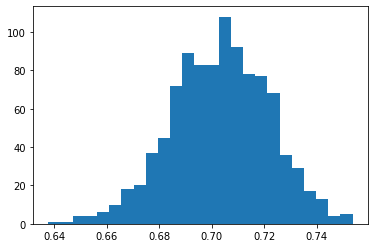

In [57]:
plt.hist(predicciones, bins=25)

In [58]:
np.percentile(predicciones, 2.5), np.percentile(predicciones, 50), np.percentile(predicciones, 97.5)

(0.665036674816626, 0.7042599153201416, 0.7386885913971921)